In [12]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from collections import Counter


class TrajectoryPlotter:
    def __init__(self):
        self.fig = plt.figure(figsize=(10, 8))
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.trajectories = []

    def add_trajectory(self, poses, color, label):
        """
        Add the 3D trajectory of the given poses to the plot.
        
        Parameters:
        poses (list): A list of 4x4 transformation matrices representing the poses.
        color (str)
        label (str): The label for the trajectory.
        """
        self.trajectories.append((poses, color, label))

    def plot_all(self):
        """
        Plot all the added trajectories and display the plot.
        """
        # Plot all the trajectories
        for poses, color, label in self.trajectories:
            plot_color = color[0].lower() + '-'
            # colors = [cm.get_cmap(color + 's')( i / len(poses)) for i in range(len(poses))]
            colors = [cm.get_cmap(color + 's') ( (i + 0.7*len(poses)) / (2*len(poses)) ) for i in range(len(poses))]
            # Extract the x, y, z coordinates from the transformation matrices
            poses_x = [pose[0, 3] for pose in poses]
            poses_y = [pose[1, 3] for pose in poses]
            poses_z = [pose[2, 3] for pose in poses]
            
            n_points = len(poses_x)
            
            # Plot the trajectory with color gradient
            for i in range(n_points - 1):
                self.ax.plot([poses_x[i], poses_x[i+1]], [poses_y[i], poses_y[i+1]], [poses_z[i], poses_z[i+1]], color=colors[i])
            self.ax.plot([], [], plot_color, label=label)

        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_zlabel('Z')
        self.ax.set_zlim(0, 1)
        self.ax.set_title('Trajectory')

        
        # Add legend
        self.ax.legend()
        
        self.ax.grid(True)
        plt.show()

def read_csv_file(file_path):
    """
    Read the CSV file and return the real and estimated poses.
    """
    real_poses = []
    estimated_poses = []
    
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            estimated_pose = np.array([float(x) for x in row[:16]]).reshape(4, 4)
            real_pose = np.array([float(x) for x in row[16:]]).reshape(4, 4)
            real_poses.append(real_pose)
            estimated_poses.append(estimated_pose)
    
    return real_poses, estimated_poses


def calculate_ATE(real_poses, estimated_poses):
    """
    Calculate the Absolute Trajectory Error (ATE) between the real and estimated poses.

    Parameters:
    real_poses (list): A list of 4x4 transformation matrices representing the real poses.
    estimated_poses (list): A list of 4x4 transformation matrices representing the estimated poses.

    Returns:
    tuple: (translation_rmse, rotation_rmse)
        translation_rmse (float): The Absolute Trajectory Error (ATE) in translation.
        rotation_rmse (float): The Absolute Trajectory Error (ATE) in rotation.
    """
    assert len(real_poses) == len(estimated_poses), "Real and estimated poses must have the same length."

    translation_errors = []
    rotation_errors = []
    for i in range(len(real_poses)):
        real_pose = real_poses[i]
        estimated_pose = estimated_poses[i]

        # Calculate the transformation error between the real and estimated poses
        pose_error = np.matmul(np.linalg.inv(real_pose), estimated_pose)

        # Extract the translation and rotation components
        translation_component = pose_error[:3, 3]
        rotation_component = pose_error[:3, :3]

        # Calculate the translation error
        translation_error = np.linalg.norm(translation_component)
        translation_errors.append(translation_error)

        # Calculate the rotation error as the sum of squared differences between the elements
        rotation_error = np.sum(np.square(rotation_component - np.eye(3)))
        rotation_errors.append(rotation_error)

    translation_rmse = np.sqrt(np.mean(np.square(translation_errors)))
    rotation_rmse = np.sqrt(np.mean(rotation_errors))

    return translation_rmse, rotation_rmse

def calculate_RTE(real_poses, estimated_poses):
    """
    Calculate the Relative Trajectory Error (RTE) between the real and estimated poses.

    Parameters:
    real_poses (list): A list of 4x4 transformation matrices representing the real poses.
    estimated_poses (list): A list of 4x4 transformation matrices representing the estimated poses.

    Returns:
    tuple: (translation_error, rotation_error)
        translation_error (float): The Relative Trajectory Error (RTE) in translation.
        rotation_error (float): The Relative Trajectory Error (RTE) in rotation.
    """
    assert len(real_poses) == len(estimated_poses), "Real and estimated poses must have the same length."

    translation_errors = []
    rotation_errors = []
    
    for i in range(1, len(real_poses)):
        real_relative_pose = np.linalg.inv(real_poses[i-1]) @ real_poses[i]
        estimated_relative_pose = np.linalg.inv(estimated_poses[i-1]) @ estimated_poses[i]

        # Calculate the transformation error between the real and estimated relative poses
        relative_pose_error = np.matmul(np.linalg.inv(real_relative_pose), estimated_relative_pose)

        # Extract the translation and rotation components
        translation_component = relative_pose_error[:3, 3]
        rotation_component = relative_pose_error[:3, :3]

        # Calculate the translation error
        translation_error = np.linalg.norm(translation_component)
        translation_errors.append(translation_error)

        # Calculate the rotation error as the sum of squared differences between the elements
        rotation_error = np.sum(np.square(rotation_component - np.eye(3)))
        rotation_errors.append(rotation_error)

     
    translation_rmse = np.sqrt(np.mean(np.square(translation_errors)))
    rotation_rmse = np.sqrt(np.mean(rotation_errors))

    return translation_rmse, rotation_rmse


In [34]:

# Usage
# file_path = "/home/clp/catkin_ws/src/lias_anp/record/anp/o/atraj.csv"  # Replace with your CSV file path
file_path = "/home/clp/catkin_ws/src/lias_anp/record/anp/circle_no3D_gt2D_same_direction/atraj.csv"  # Replace with your CSV file path
real_poses1, estimated_poses_anp = read_csv_file(file_path)


print(calculate_ATE(real_poses1, estimated_poses_anp))
print(calculate_RTE(real_poses1, estimated_poses_anp))

translation = real_poses1[0][:3, 3].T - estimated_poses_anp[0][:3, 3].T
np.linalg.norm(translation)

(0.024894994802993578, 0.03819771896472604)
(0.002924605241457568, 0.003537082677085734)


5.078878944053211e-06

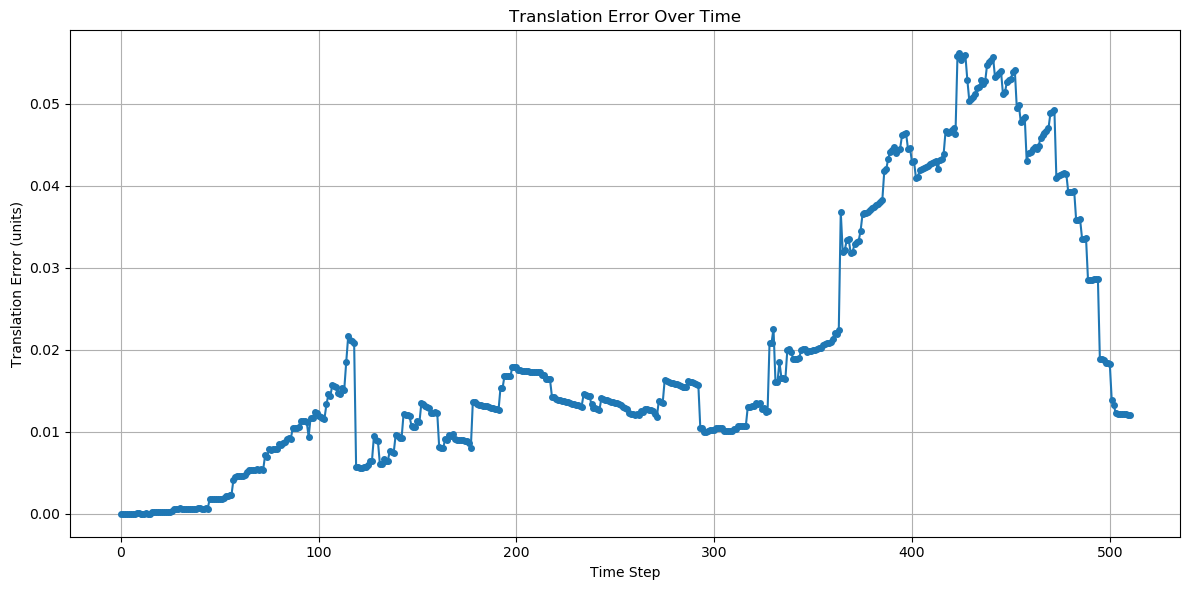

In [37]:
list1 = np.array([3.3938645235878284, 2.7030828629841266, 4.240120691721977, 2.395445718141245, 6.838694097584941, 7.658094916290872, 3.5086966005635722, 6.157882032673659, 3.742679599408224, 6.080782996717713, 5.429285167687702, 4.688314674249751, 5.209319231866543, 3.0332179815004032, 1.963357481955188, 2.390932435451202, 4.523012810360145, 5.0234875337499405, 2.4488117478568148, 2.220254352705824, 2.854399060633491, 2.8194460862834507, 5.9482906205136565, 2.869991215485907, 4.400742061676538, 3.454362021789388, 2.2766057417082637, 1.655027374828396, 5.6081121798806395, 6.559257711074176, 2.970433536569652, 4.00069581513816, 7.334048725846326])
list2 = np.array([8.104620743159296, 7.334776412479666,   7.653987640298525, 4.874997530544998, 5.251584028798012, 6.598420614830081, 6.88933652201751, 4.8926656972713625, 7.343731068458253, 4.551830996388567, 4.0684112604934315, 3.573235650738288, 6.687381620368645, 3.86266401888387, 5.065477977021508, 3.67499066924846, 7.4836767636871695, 6.85580310750079, 4.8890221563582745, 3.860967392517289, 6.773720690723951, 6.232467967616559, 4.745057207312247, 8.271189217154369, 5.571710588925519, 6.088996401448875, 3.454479495377231, 3.5292983019849236, 5.4163904225211965, 5.154050682347283, 4.253345156986405, 2.9851369267318595, 6.352241929731639])
def calculate_translation_error(real_pose, estimated_pose):
    translation = real_pose[:3, 3] - estimated_pose[:3, 3]
    return np.linalg.norm(translation)

# 假设我们有N个时间步
N = len(estimated_poses_anp)

# 计算每个时间步的平移误差
errors = [calculate_translation_error(real_poses1[i], estimated_poses_anp[i]) for i in range(N)]

# 创建时间步索引
time_steps = list(range(N))

# 绘制折线图
plt.figure(figsize=(12, 6))
plt.plot(time_steps, errors, marker='o', linestyle='-', markersize=4)

plt.title('Translation Error Over Time')
plt.xlabel('Time Step')
plt.ylabel('Translation Error (units)')

plt.grid(True)
plt.tight_layout()

plt.show()


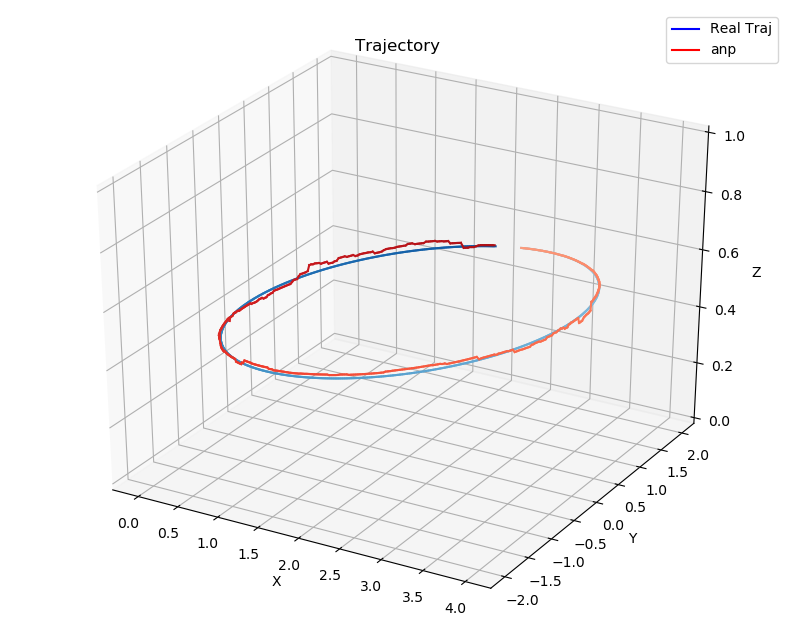

In [38]:
# length_list = []
# for i in range(1, len(real_poses1)):
#     translation = real_poses1[i][:3, 3].T - real_poses1[i-1][:3, 3].T
#     length_list.append(np.linalg.norm(translation))
# length_list.sort(reverse=True)
# formatted_list = [float('{:.4g}'.format(num)) for num in length_list]

# count = Counter(formatted_list)
# for item, frequency in count.items():
#     print(f"{item}: {frequency}")



plotter = TrajectoryPlotter()

# Add the real trajectory
plotter.add_trajectory(real_poses1, 'Blue', 'Real Traj')

# Add the estimated trajectory
plotter.add_trajectory(estimated_poses_anp, 'Red', 'anp')

# Plot all the added trajectories
plotter.plot_all()